In [41]:
import torch
from torch import nn
from d2l import torch as d2l
import torchvision
import torch.utils.data as data
import torchvision.transforms as transforms

与原始的LeNet相比，去掉了最后一层的高斯激活。
https://zh.d2l.ai/_images/lenet.svg
https://zh.d2l.ai/_images/lenet-vert.svg

In [42]:
net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5, padding=2), 
    nn.Sigmoid(),  # 当时只有sigmoid激活函数，没有relu激活函数
    nn.AvgPool2d(kernel_size=2, stride=2),  # 当时只有平均池化，没有最大池化
    nn.Conv2d(6, 16, kernel_size=5), 
    nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(16 * 5 * 5, 120), 
    nn.Sigmoid(),
    nn.Linear(120, 84), 
    nn.Sigmoid(),
    nn.Linear(84, 10))

检查每一层的输出形状。
在卷积过程中，图像的宽和高在不断变小，但通道数在一直增加

In [43]:
X = torch.rand(size=(1, 1, 28, 28), dtype=torch.float32)
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape: \t',X.shape)

Conv2d output shape: 	 torch.Size([1, 6, 28, 28])
Sigmoid output shape: 	 torch.Size([1, 6, 28, 28])
AvgPool2d output shape: 	 torch.Size([1, 6, 14, 14])
Conv2d output shape: 	 torch.Size([1, 16, 10, 10])
Sigmoid output shape: 	 torch.Size([1, 16, 10, 10])
AvgPool2d output shape: 	 torch.Size([1, 16, 5, 5])
Flatten output shape: 	 torch.Size([1, 400])
Linear output shape: 	 torch.Size([1, 120])
Sigmoid output shape: 	 torch.Size([1, 120])
Linear output shape: 	 torch.Size([1, 84])
Sigmoid output shape: 	 torch.Size([1, 84])
Linear output shape: 	 torch.Size([1, 10])


In [44]:
batch_size = 256
# train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size=batch_size)
def load_data_mnist(batch_size, resize=None):
    """下载MNIST数据集，然后将其加载到内存中"""
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.MNIST(
        root="../data", train=True, transform=trans, download=True)
    mnist_test = torchvision.datasets.MNIST(
        root="../data", train=False, transform=trans, download=True)
    return (data.DataLoader(mnist_train, batch_size, shuffle=True, num_workers=4),
            data.DataLoader(mnist_test, batch_size, shuffle=False, num_workers=4))

train_iter, test_iter = load_data_mnist(batch_size=batch_size)

Failed to download (trying next):
HTTP Error 503: Service Unavailable



100.0%


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable



100.0%


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable



100.0%


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable



100.0%

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw


In [45]:
def evaluate_accuracy_gpu(net, data_iter, device=None): #@save
    """使用GPU计算模型在数据集上的精度"""
    if isinstance(net, nn.Module):
        net.eval()  # 设置为评估模式
        if not device:
            device = next(iter(net.parameters())).device
    # 正确预测的数量，总预测的数量
    metric = d2l.Accumulator(2)
    with torch.no_grad():
        for X, y in data_iter:
            if isinstance(X, list):
                # BERT微调所需的（之后将介绍）
                X = [x.to(device) for x in X]
            else:
                X = X.to(device)
            y = y.to(device)
            metric.add(d2l.accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

In [46]:
#@save
def train_ch6(net, train_iter, test_iter, num_epochs, lr, device):
    """用GPU训练模型(在第六章定义)"""
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
    net.apply(init_weights)
    print('training on', device)
    net.to(device)
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])
    timer, num_batches = d2l.Timer(), len(train_iter)
    for epoch in range(num_epochs):
        # 训练损失之和，训练准确率之和，样本数
        metric = d2l.Accumulator(3)
        net.train()
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (train_l, train_acc, None))
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(device)}')
    # 输出LeNet中两个卷积层卷积计算之后的图像
    x_first_Sigmoid_layer = net[0:2](X)[0:9, 1, :, :].cpu()  # [0:9]表示选9张图片，第二个1表示选第二个通道（一共6个，选哪个都行）
    d2l.show_images(x_first_Sigmoid_layer.reshape(9, 28, 28).detach().numpy(), 1, 9)  # reshape(9,28,28)中9代表选9个图片，(28,28)是为了和LeNet的第一个卷积层的输出形状一致。
    x_second_Sigmoid_layer = net[0:5](X)[0:9, 1, :, :].cpu()
    d2l.show_images(x_second_Sigmoid_layer.reshape(9, 10, 10).detach().numpy(), 1, 9)  # reshape(9,10,10)中9代表选9个图片，(10,10)是为了和LeNet的第二个卷积层的输出形状一致。

loss 0.114, train acc 0.965, test acc 0.970
21926.7 examples/sec on mps


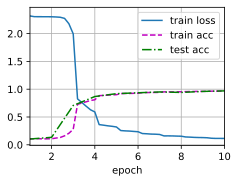

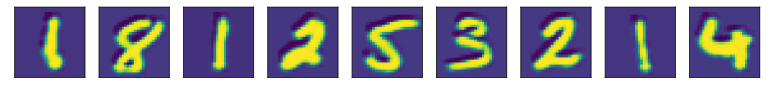

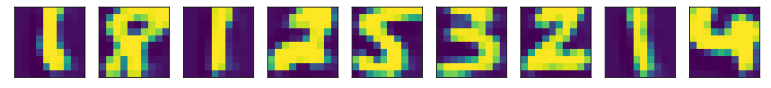

In [47]:
lr, num_epochs = 0.9, 10
train_ch6(net, train_iter, test_iter, num_epochs, lr, device="mps")